In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1 Author

**Student Name**: Danielle Souza Da Silva



# 2 Problem formulation

In this notebook, we will be formulating a binary classification problem. We will build a machine learning pipeline that takes as an input a Potter or a StarWars audio segment and then predicts its song label. I will be using 416 audio files in total, all files from part 1 Potter and all files from part 1 StarWars from the MLEnd Data Set.

This machine learning problem is very exciting as we will be exploring audio signal features. It will allow us to improve our knowledge on how these features can be used to solve this specific problem and to find which features are most relevant for the machine learning model. This problem is interesting since we will be able to train a model which will be able to recognise which song a person may be humming or whistling to. 

# 3 Machine Learning pipeline

#### **Data Preprocessing &#8594; Feature Engineering &#8594; Data Transformation &#8594; Feature Selection &#8594; Model Selection &#8594; Prediction**

My Machine Learning pipeline consists of 6 stages:

* **Stage 1 Data Preprocessing:** 

This stage will take the inconsistent audio files names as input and produce adjusted audio file names.

In this stage, I have manually adjusted the file names. I have used the pandas library to make the data set for the audio files and to extract information regarding the audio names.

* **Stage 2 Feature Engineering:**

This stage will take the audio files as an input and produce the following features: power, pitch mean, pitch standard deviation, fraction of voiced region, spectral centroids mean, mfcc coefficients mean, chroma mean, the rms mean and the zero_crossing mean.

In this stage, I have used the librosa library to extract these audio features. I also used the functions from the MLEnd Starter kit lab to extract the feature values.

* **Step 3 Data Transformation:**

This stage will take the the class label y (songs Potter and StarWars) as an input and produce a binary class values. It will also take the features as an input and produce normalised set of features.

In this stage, I have used the sklearn library and the StandardScaler function to normalise all features. 

* **Step 4 Feature Selection:**

This stage will take the above audio features as an input and produce as an output the most relevant features for the model.

In this stage, I have used sklearn.feature_selection library and SelectFromModel to select the features in which have the most weight and therefore importance.

* **Step 5 Model Selection:**

This stage will take Logistic Regression and Random Forest models and output the model in which provides the best results for this machine learning problem.

* **Step 6 Prediction:**

This stage will take the training, validation and test data sets as input and produce the performance metrics (accuracies) as an output by using the models.

# 4 Transformation stage

The transformation stage will be ideal to make sure we have a suitable representation of our data for our models.


* **Step 1 Feature Extraction:**

In this step, I will use the same feature extraction method as it was used in the MLEnd Starter kit lab. I will be using a function to extract the audio features: power, pitch mean, pitch standard deviation, fraction of voiced region, the spectral centroid mean, the mfcc coefficient mean, the RMS mean and zero-crossing rate mean. The input will be the 96 audio files and output will be the mentioned feature values in a Numpy array.

* **Step 2 Linear Transformation:**

This stage will take the value of features mentioned above and produce as an output normalised set of features. I will use the sklearn standard scaler function to perform these transformations. 

 * **Step 3 Dimensionality Reduction:**

This stage will take the features as an input and produce as an output the most relevant features for the model. I will use the SelectFromModel function from the sklearn library to perform this transformation for the Random Forest model.

# 5 Modelling

I will be implementing two machine learning supervised classification algorithms for this machine learning problem:

The **Random Forest** is an ensemble learning method for classification and regression which works by constructiong a large number of decision trees. Each tree in the random forest will give a class prediction and the class with the most "votes" will become the model's final prediction results. $^1$

The **Binary Logistic Regression** is a statistical technique used to predict a set of categorical binary target labels based on the independent variables which are the predictors. In our case, the predictors would be the audio features and the target variables the songs potter or star wars. In the Logistic Regression model, the log of odds of the dependent variable is modeled as a linear combination of the independent variables (predictors). $^2$

---

*References:*

---

$^1$ 

https://en.wikipedia.org/wiki/Random_forest

https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706

https://towardsdatascience.com/understanding-random-forest-58381e0602d2

---

$^2$ 

https://towardsdatascience.com/implementing-binary-logistic-regression-in-r-7d802a9d98fe

---

# 6 Methodology

I will split the data set into four parts. Firstly, I will split the training and test data set which will have 4:1 ratio. Then I will use the training the data set to split it into a new training data set in which will be used to tune the models and a validation data set which will have a 4:1 ratio as well.

The **training data sets** will be used to tune the model by finding the best values for the models parameters.

The **validation data sets** will be used to provide an unbiased evaluation of the models fit after each model has been tuned so that the "best" model can be selected. 

The **test data sets** will be used to estimate the model's deployment performance which is the most important task. 

The **quality metrics** that will be used to quantify each models performance will be the accuracy and the area under the curve ROC metric.

# 7 Dataset

The data set that I will use is the Part 1 Potter and Part 1 StarWars from the MLEnd Data Set. In total, we have 416 audio files.


The first step is to load the audio files to the notebook:

In [2]:
sample_path = '/content/drive/MyDrive/Data/MLEndHW/sample_potter_sw/*.wav'
files_potter_sw = glob.glob(sample_path)
len(files_potter_sw)

416

To have a table-like structure the Python lists and the split function was used to extract the information from the audio names. Then, the table was loaded into a pandas data frame to explore additional information from the audio file names. This step was done in the same way that it was done in the starter kit lab.

In [3]:
PotterSW = [] 

for file in files_potter_sw:
  file_name = file.split('/')[-1]
  participant_ID = file.split('/')[-1].split('_')[0]
  interpretation_type = file.split('/')[-1].split('_')[1]
  interpretation_number = file.split('/')[-1].split('_')[-2]
  song = file.split('/')[-1].split('_')[-1].split('.')[0]
  PotterSW.append([file_name,participant_ID,interpretation_type,interpretation_number, song])

PotterSw_df = pd.DataFrame(PotterSW,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 

Here, I have adjusted the split audio names, some of the Potter and StarWars had the wrong format or were mispelt in the sample files, the same happened for the interpretation names. So, I have changed the names in the next step.

In [4]:
PotterSw_df['song'].replace({'[Potter]':'Potter', 'potter':'Potter', '[potter]':'Potter', 'harry potter':'Potter', 'Potterwav':'Potter',
                          'Potter ':'Potter', 'Starwars':'StarWars', 'starwar':'StarWars', '[StarWars]':'StarWars', 'starwars':'StarWars', '[ Star Wars ]':'StarWars',
                          '[StatWars]':'StarWars','[Starwars]':'StarWars', 'StarsWars':'StarWars', 'Star wars':'StarWars', 'star wars':'StarWars', 'StarWar':'StarWars'}, inplace=True)

PotterSw_df['interpretation'].replace({'hum':'Hum', 'whistle':'Whistle', 'whisle':'Whistle'}, inplace=True)
PotterSw_df

participant interpretation number      song
file_id                                                               
S1_hum_2_Potter.wav                 S1            Hum      2    Potter
S1_whistle_2_Potter.wav             S1        Whistle      2    Potter
S2_hum_2_Potter.wav                 S2            Hum      2    Potter
S2_whistle_2_Potter.wav             S2        Whistle      2    Potter
S3_hum_1_Potter.wav                 S3            Hum      1    Potter
...                                ...            ...    ...       ...
S55_whistle_2_StarWars.wav         S55        Whistle      2  StarWars
S95_Hum_1_StarWars.wav             S95            Hum      1  StarWars
S95_Hum_2_Potter.wav               S95            Hum      2    Potter
S95_Whistle_1_StarWars.wav         S95        Whistle      1  StarWars
S95_Whistle_2_Potter.wav           S95        Whistle      2    Potter

[416 rows x 4 columns]

The following audio signals show the humming sounds from two candidates to the song Potter and StarWars. We can see that even though the candidates would also affect the audio signal. They are quite different from each other. This could allow us to explore audio features in which are relevant for the model to distinguish between Potter and StarWars.

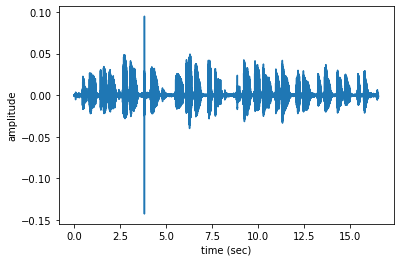

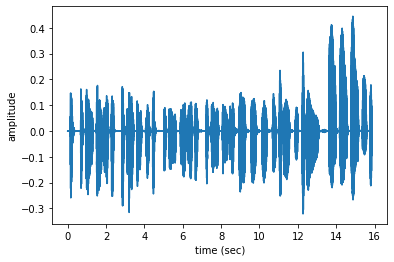

In [5]:
songs=[0, 412]
for n in songs:
  fs = None # Sampling frequency. If None, fs would be 22050
  x, fs = librosa.load(files_potter_sw[n],sr=fs)
  t = np.arange(len(x))/fs
  plt.plot(t,x)
  plt.xlabel('time (sec)')
  plt.ylabel('amplitude')
  plt.show()
  display(ipd.Audio(files_potter_sw[n]))

For the feature extraction stage, I have used the same function as used in the lab as it was an efficient method to extract the audio features.

The following are the audio features in which will be used as predictors in the machine learning models chosen. The features extracted are:

1. Power.

2. Pitch mean.

3. Pitch standard deviation.

4. Fraction of voiced region.

5. The spetral centroid mean

6. mfcc coefficients mean

7. chroma mean

8. The RMS mean

9. The zero-crossing rate

I have selected these range of features according to what they possess. For example, the RMS mean will provide higher value when the audio is higher in amplitude and therefore a higher RMS means that we will perceive a sound as louder. This could be useful for our model since each candidate humming or whistling to each song would have an unique RMS mean at different times of the songs.

The following functions will take the audio files and provide an array of the features extracted as an output.

In [6]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [7]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    #print(file_name)
    #print(labels_file.loc[fileID]['interpretation'])
    #print(labels_file.loc[fileID]['interpretation']=='hum')
    #yi = list(labels_file.loc[fileID]['interpretation'])[0]=='hum'
    yi = labels_file.loc[fileID]['song']=='Potter'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    spectral_centroids_mean = np.mean(librosa.feature.spectral_centroid(x, sr=fs))
    mfcc_mean = np.mean(librosa.feature.mfcc(y=x, sr=fs))
    chroma_mean = np.mean(librosa.feature.chroma_stft(y=x, sr=fs))
    rms = np.mean(librosa.feature.rms(y=x))
    zero_crossing = np.mean(librosa.feature.zero_crossing_rate(x))

    xi = [power,pitch_mean,pitch_std,voiced_fr, spectral_centroids_mean, mfcc_mean, chroma_mean,rms,zero_crossing]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

I have saved the data frame including the features extracted with the labels to be able to use it for the models.

In [8]:
potter_sw_xy = pd.read_csv('potter_sw_df_2.csv')
del potter_sw_xy['Unnamed: 0']
potter_sw_xy

Power  Pitch_mean  Pitch_std  ...       rms  zero_crossing  PotterVsStarWars
0    0.001961  107.628769  14.832539  ...  0.032111       0.036607              True
1    0.020419  408.684951  31.757141  ...  0.116072       0.090304              True
2    0.053579  179.379037  47.894724  ...  0.205222       0.019544              True
3    0.037227  396.012292  40.644200  ...  0.141385       0.068537              True
4    0.093276  184.280074  27.611400  ...  0.272731       0.013935              True
..        ...         ...        ...  ...       ...            ...               ...
411  0.400333  406.165577  26.201293  ...  0.529072       0.071486             False
412  0.016557  105.155667  20.033936  ...  0.087873       0.033516             False
413  0.024138  105.818240  20.168317  ...  0.104850       0.021117              True
414  0.008699  429.272436  14.983587  ...  0.055696       0.123300             False
415  0.004656  396.343661  32.761819  ...  0.027801       0.061938              True

[416 rows x 10 columns]

Transforming the data frame for the features as an numpy array.

In [9]:
X = potter_sw_xy.drop(columns=['PotterVsStarWars'])
X_ = X.to_numpy()

Transforming the data frame for the target variable as a numpy array.

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y = potter_sw_xy['PotterVsStarWars']
y_ = y.to_numpy()

le.fit(y_)
y_ = le.transform(y_)
y_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Now I'm going to use standard scaler from the sklearn library to normalise the feature values.

In [11]:
from sklearn.preprocessing import StandardScaler
# normalising input values using StandardScaler from sklearn.preprocessing library 

X_standard = StandardScaler().fit_transform(X_)

# 8 Results

In this part I will use the Logistic Regression and Random Forest methods to train and get a accuracy prediction for this machine learning problem.

The first step will be to split the data set into 4 parts:

The first part will have 80% for training, 20% for testing and getting a deployment performance metric.

The 80% training data will also be split into another training data set (80% of this 80%) and the validation data set (20% of this 80%). This will allow me to use these data sets to tune the models and get eventually get better metrics.

Below, we can see the training, validation and test data set shapes.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_standard,y_,test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((291, 9), (125, 9), (291,), (125,))

In [13]:
X1_train, X_val, y1_train, y_val = train_test_split(X_train,y_train,test_size=0.3)
X1_train.shape, X_val.shape, y1_train.shape, y_val.shape

((203, 9), (88, 9), (203,), (88,))

**Logistic Regression**

In this part, I will use the logistic regression function from sklearn on the training and validation data sets. Then, I will use the test data set to measure the deployment accuracy metric.

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0).fit(X1_train, y1_train)

y_train_pred = lr.predict(X1_train)
y_val_pred = lr.predict(X_val)

print('Training Accuracy', np.mean(y_train_pred==y1_train))
print('Validation  Accuracy', np.mean(y_val_pred==y_val))

Training Accuracy 0.5714285714285714
Validation  Accuracy 0.5909090909090909


As we can see above, the accuracy metrics for the training and validation data sets are very close which may imply that the model is not overfitting.

Below, we can see the result using the test data set. This would be the estimated deployment performance of the model which is considered a low performance since the accuracy score is of 0.576.

In [15]:
y_test_pred = lr.predict(X_test)
print('Test Accuracy', np.mean(y_test_pred==y_test))

Test Accuracy 0.576


**Random Forest**

Here, I will also be using the training, validation and test data sets to implement the Random Forest model.

I will show the performance metric results for selected features and all features for comparison reasons.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators=1000, random_state=0))
sel.fit(X1_train, y1_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000,
                                                 random_state=0))

I will firstly use the SelectFromModel function to select the features in which have more weight and therefore more relevance for the machine learning problem.

Below, we can see that there are 3 features in which are considered relevant for the model. 

In [17]:
selected_features = sel.get_support()
selected_features

array([False,  True,  True,  True, False, False, False, False, False])

The following are the selected features:

In [18]:
selected_feat= X.columns[(sel.get_support())]
selected_feat

Index(['Pitch_mean', 'Pitch_std', 'Fraction_voiced_region'], dtype='object')

By using the transform function I have set a new train variable to the selected relevant features.

In [19]:
X_selected_train = sel.transform(X1_train)
X_selected_val = sel.transform(X_val)

Here, I have fitted the training data sets that included the selected features to the model.

In [20]:
clf_important = RandomForestClassifier(n_estimators=1000, random_state=0)
clf_important.fit(X_selected_train, y1_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

Next, I have fitted the training data sets which include all features.

In [21]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=0)
rfc.fit(X1_train, y1_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

Below we can see the results for the training the validation data sets using all features. We get that the validation data set has a much lower score than the training data set. This may suggest the model may be overfitting.

In [22]:
from sklearn.metrics import accuracy_score

ytrain_pred = rfc.predict(X1_train)
yval_pred = rfc.predict(X_val)

# Accuracy using all features

print("Accuracy for the training data set with all features is:", accuracy_score(y1_train, ytrain_pred))

print("Accuracy for validation data set with all features is:", accuracy_score(y_val, yval_pred))

Accuracy for the training data set with all features is: 1.0
Accuracy for validation data set with all features is: 0.6136363636363636


The validation accuracy using the selected features is smaller than the validation accuracy when using all features. And, as previously, the training and validation accuracies have large differences which may suggest the model is overfitting.

In [23]:
y_selected_train_pred = clf_important.predict(X_selected_train)
y_selected_val_pred = clf_important.predict(X_selected_val)


# Accuracy using the selected features

print("Accuracy for the training data set with the selected features is:", accuracy_score(y1_train, y_selected_train_pred))

print("Accuracy for validation data set with the selected features is:", accuracy_score(y_val, y_selected_val_pred))

Accuracy for the training data set with the selected features is: 1.0
Accuracy for validation data set with the selected features is: 0.5227272727272727


The test accuracy using the model where all features were fitted has a value of 0.592 which suggest moderate performance. 

The test accuracy using the selected features is of 0.64 which suggests a much better deployment performance metric.

In [25]:
y_test_pred_rfc = clf_important.predict(sel.transform(X_test))
y_test_pred = rfc.predict(X_test)

print("Accuracy for the test data set with the selected features is:", accuracy_score(y_test, y_test_pred_rfc))
print("Accuracy for the test data set with all features is:", accuracy_score(y_test, y_test_pred))


Accuracy for the test data set with the selected features is: 0.64
Accuracy for the test data set with all features is: 0.592


# 9 Conclusions

By looking at the results, we can see that the Random Forest classifier performed a bit better than the Logistic Regression model. The test accuracy which we can use to estimate the deployment performance rate from the Random Forest Classifier was of 0.64 using the selected features. For the Logistic Regression model the test accuracy was of 0.576. The Random Forest Classifier possesses a better score when selected features were used. The test accuracy metric where all features were used has a value of 0.592 which is close to that of the Lgositic Regression. Therefore, we can say that both models performed similarly.

As observed, the Random Forest gave us signs that the model was overfitting during the training and validation stages. I have attempted to improve this by changing a few parameters on the model in which did not change the results. I am assuming that the reason for overfitting may be because of the amount of data used for the training data set and/or the parameters in which may have needed more adjustments. I tried to increase the training data sets but the results did not change. Therefore, I consider that this is an area for improvement when using this model.

Also, I have observed that if more features were explored for this specific machine learning problem, the model could have had a better performance. By doing feature selection we can see that the model is more prone to have better results.


